In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from pymongo import MongoClient
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_mongo_database(db_name, host='localhost',
                       port=27017, username=None, password=None):
    """ Get named database from MongoDB with/out authentication """
    # make Mongo connection with/out authentication
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s/%s'%(username, password, host, db_name)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)

    return conn[db_name]

def mongo_coll_to_dicts(dbname='test', collname='test',
                        query={}, del_id=True, **kw): 

    db = get_mongo_database(dbname, **kw)
    res = list(db[collname].find(query))

    if del_id:
        for r in res:
            r.pop('_id')

    return res

def mongo_to_dataframe(db_name, collection, query={},
                       host='localhost', port=27017,
                       username=None, password=None, no_id=True):
    """ create a dataframe from mongodb collection """
    db = get_mongo_database(db_name, host, port, username, password)
    cursor = db[collection].find(query)
    df =  pd.DataFrame(list(cursor))

    if no_id: 
        del df['_id']

    return df

def dataframe_to_mongo(df, db_name, collection,
                       host='localhost', port=27017,
                       username=None, password=None):
    """ save a dataframe to mongodb collection """
    db = get_mongo_database(db_name, host, port, username, password)
    records = df.to_dict('records')
    db[collection].insert_many(records)

In [3]:
DB_NOBEL_PRIZE='nobel_prize'
COLL_WINNERS='winners'
COLL_WINNERS_CLEAN='winners_clean'
COLL_MIN_BIO='mini_bio'
COLL_FULL_DATA='full_data'

In [4]:
df=mongo_to_dataframe(DB_NOBEL_PRIZE, COLL_FULL_DATA)

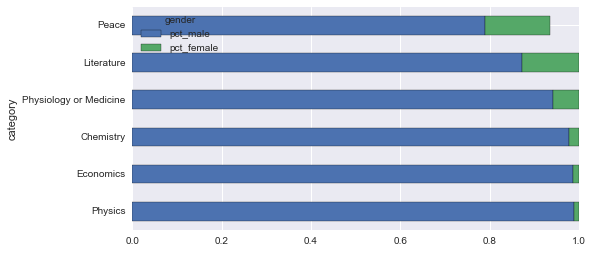

In [10]:
#total proportion of female winners by category
df_cat_gender=g_cat_gender.size().unstack()
df_cat_gender['total']=df_cat_gender.sum(axis=1)
df_cat_gender['pct_female']=df_cat_gender['female']/df_cat_gender['total']
df_cat_gender['pct_male']=df_cat_gender['male']/df_cat_gender['total']
df_cat_gender[['pct_male','pct_female']].sort_values('pct_female',ascending=True).plot(kind='barh',stacked=True)

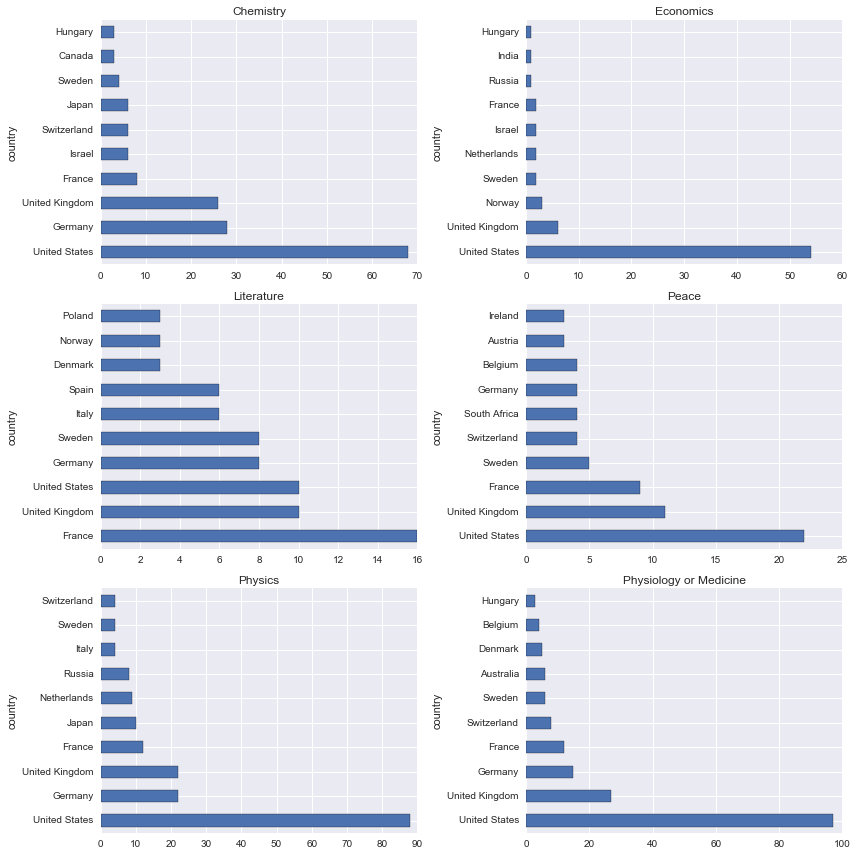

In [15]:
#create a multiplot to see the top 10 countries for each categorie in term of total number of winners
g_country_cat=df.groupby(['country','category']).size().unstack()
N_ROWS=3
N_COLS=2
fig,axes=plt.subplots(N_ROWS,N_COLS,figsize=(12,12))
for i,(col_label, col) in enumerate(g_country_cat.iteritems()):
    ax=axes[i/N_COLS,i%N_COLS]
    col=col.sort_values(ascending=False)[:10]
    col.plot(kind='barh',ax=ax)
    ax.set_title(col_label)
plt.tight_layout()

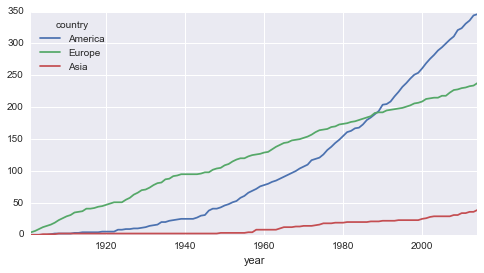

In [17]:
#historical trends by regions (main winning countries by regions)
regions=[
    {
        'label':'America',
        'countries':['United States','Canada']
    },
    {
        'label':'Europe',
        'countries':['United Kingdom','Germany','France']
    },
    {
        'label':'Asia',
        'countries':['Russia','China','Japan']
    }
]
for region in regions:
    g_year_country[region['label']] = g_year_country[region['countries']].sum(axis=1)
g_year_country[[r['label'] for r in regions]].fillna(0).cumsum().plot()

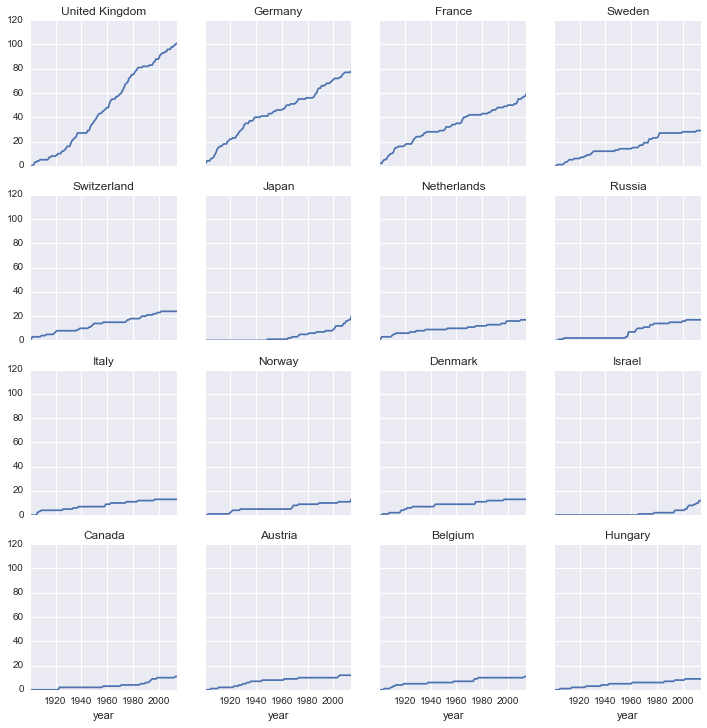

In [18]:
#let's take a look at the trajectory of the 16 main countries excl. the US
#identification of 16 main countries
g_country=df.groupby('country').size().sort_values(ascending=False)

N_ROWS=4
N_COLS=4

fig, axes= plt.subplots(N_ROWS, N_COLS, figsize=(12,12), sharex = True, sharey = True)

for i, nat in enumerate(g_country.index[1:17]):
    ax=axes[i/N_COLS, i%N_COLS]
    g_year_country[nat].fillna(0).cumsum().plot(ax=ax)
    ax.set_title(nat)

In [5]:
def map_to_index(df, col):
    mapper={};
    for i, country in enumerate(df[col].unique()):
        mapper[country]=i;
    return mapper

In [10]:
def prepare_heatmap(df, x_dimension, y_dimension, binXNum=10, binYNum=False, topY=17, exclude_Y=['United States']):
    
    if exclude_Y:
        df = df[~df[y_dimension].isin(exclude_Y)]
        
    if topY:
        grouped_Y = df.groupby(y_dimension).size().sort_values(ascending=False).reset_index()
        top_index = grouped_Y[y_dimension][0:topY];
        df = df[df[y_dimension].isin(top_index)];
    
    if binXNum:
        binX=np.arange(df[x_dimension].min(),df[x_dimension].max(),binXNum)
        groupX = pd.cut(df[x_dimension], bins=binX, precision=0)
    else:
        groupX = x_dimension
    
    if binYNum:
        binY=np.arange(df[y_dimension].min(),df[y_dimension].max(),binXNum)
        groupY = pd.cut(df[y_dimension], bins=binY, precision=0)
    else:
        groupY = y_dimension
    
    df_heat = df.groupby([groupX,groupY]).size().unstack().fillna(0)
    df_heat = df_heat.stack().reset_index()
    
    x_mapper, y_mapper = map_to_index(df_heat, x_dimension), map_to_index(grouped_Y, y_dimension)
    df_heat['x_index'] = df_heat[x_dimension].astype('str').map(lambda x : x_mapper[x])
    df_heat['y_index'] = df_heat[y_dimension].map(lambda x : y_mapper[x])
    
    df_heat.rename(columns={0:'my_value'}, inplace=True)
    
    return df_heat

In [11]:
data_heat = prepare_heatmap(df, 'year','country')

In [12]:
data_heat.y_index.unique()

array([13, 14, 12, 10,  2,  1, 15, 11,  8,  5,  6,  9,  7, 16,  3,  4,  0])

In [130]:
dataframe_to_mongo(data_heat, DB_NOBEL_PRIZE, 'heatmap',
                   host='localhost', port=27017,
                    username=None, password=None)

In [15]:
data_heat.to_csv('data_heatmap_V2.csv')

In [16]:
pd.read_csv('data_heatmap_V2.csv')

,Unnamed: 0,year,country,my_value,x_index,y_index
0,0,"(1901, 1911]",Austria,2.0,0,13
1,1,"(1901, 1911]",Belgium,3.0,0,14
2,2,"(1901, 1911]",Canada,0.0,0,12
3,3,"(1901, 1911]",Denmark,2.0,0,10
4,4,"(1901, 1911]",France,9.0,0,2
5,5,"(1901, 1911]",Germany,13.0,0,1
6,6,"(1901, 1911]",Hungary,1.0,0,15
7,7,"(1901, 1911]",Israel,0.0,0,11
8,8,"(1901, 1911]",Italy,4.0,0,8
9,9,"(1901, 1911]",Japan,0.0,0,5


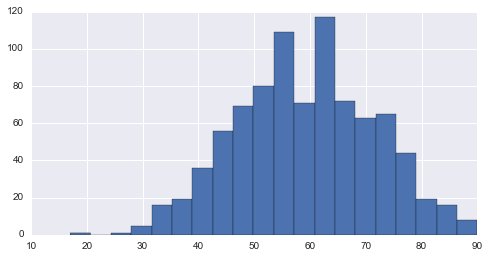

In [272]:
#distribution of age at the time of price attribution
df['award_age'].hist(bins=20)

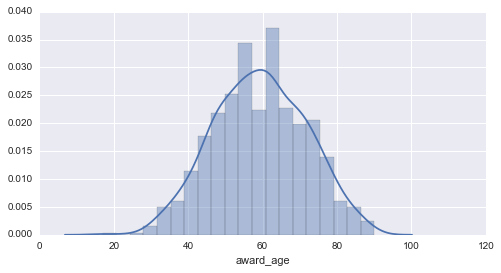

In [276]:
sns.distplot(df['award_age'].dropna())

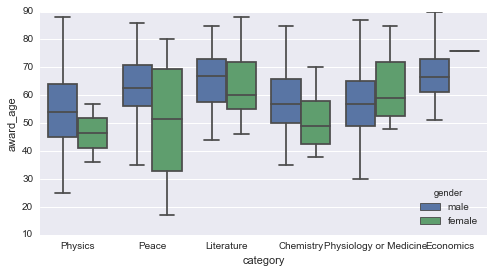

In [289]:
#using boxplots
df_aw=df[df.award_age.notnull()]
palette={'male':'blue', 'female':'red'}
sns.boxplot(y='award_age', x='category', data=df_aw, hue='gender')

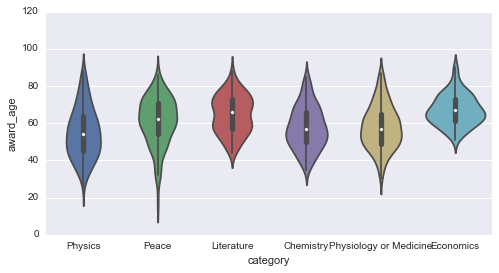

In [293]:
#using volinplots
df_aw=df[df.award_age.notnull()]
palette={'male':'blue', 'female':'red'}
sns.violinplot(y='award_age', x='category', data=df_aw)

In [27]:
#looking at age of death
df['age_of_death']=(pd.to_datetime(df.date_of_death,errors='coerce') - pd.to_datetime(df.date_of_birth,errors='coerce')).dt.days/365 

In [35]:
#problem with age pf death ==> should rerun the cleaning steps and identify issue
df[df.age_of_death<40].shape

(248, 16)

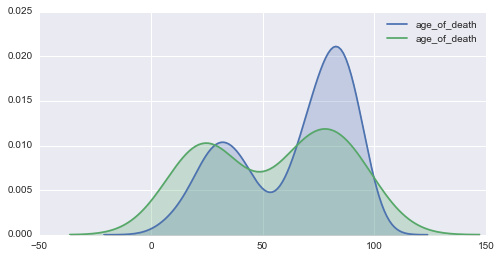

In [30]:
sns.kdeplot(df.loc[(df.age_of_death>0)&(df.gender=='male'),'age_of_death'],shade=True)
sns.kdeplot(df.loc[(df.age_of_death>0)&(df.gender=='female'),'age_of_death'],shade=True)

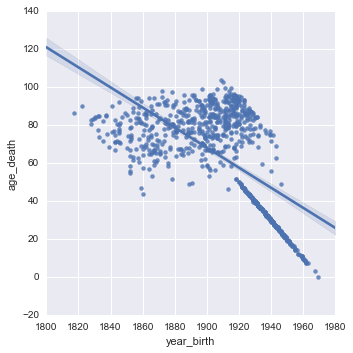

In [33]:
data=DataFrame({'age_death':df[(df.age_of_death>0)&(df.date_of_death.notnull())].age_of_death,'year_birth':df[df.age_of_death>0].date_of_birth.dt.year})
sns.lmplot('year_birth','age_death',data)

In [38]:
#aller récupérer le born_in field dans le pipe de cleaning pour pouvoir sortir la heatmap born_in ==> moved to

Index([      u'award_age',        u'category',         u'country',
         u'date_of_birth',   u'date_of_death',          u'gender',
            u'image_urls',            u'link',        u'mini_bio',
                  u'name',  u'place_of_birth',  u'place_of_death',
       u'receiver_nature',            u'text',            u'year',
          u'age_of_death'],
      dtype='object')